# Zero-shot integration tutorial with scGPT

## Introduction

This tutorial covers the zero-shot integration with scGPT. This particular workflow achieves accurate and fast batch effect removal for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT, and you may refer to [fine-tuning tutorial](./Tutorial_Integration.ipynb).


We will use the Lung-Kim dataset as an example. The dataset comprises 14 primary human lung adenocarcinoma samples and 32,493 cells. This dataset is publicly accessible via the [Curated Cancer Cell Atlas](https://www.weizmann.ac.il/sites/3CA/lung), which can be downloaded from [here](https://drive.google.com/file/d/1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL/view?usp=sharing). You may place the dataset under `save/data` directory.

For scGPT model weight, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y).


The zero-shot integration workflow is as follows:

 1. Load and pre-process the dataset
    
 2. Generate scGPT embeddings for each cell

At the end of this tutorial, we will also showcase the zero-shot integration performance on COVID-19 dataset and Multiple Sclerosis (M.S.) dataset, you can find and download the datasets here: [COVID-19](https://drive.google.com/file/d/1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x/view?usp=drive_link) and [MS](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing)

## Import scGPT and dependencies

In [1]:
from pathlib import Path
import scanpy as sc
import scib
import numpy as np
import sys

sys.path.insert(0, "../")

import scgpt as scg
import matplotlib.pyplot as plt
import anndata

plt.style.context('default')

model_dir = Path("../save/scGPT_human")

## Set up evaluation function

We set up the evaluation function, we mainly compare the integration performance on avgBIO and avgBATCH. Refer to our manuscript for more details.

In [2]:
"""
Calculate the metrics for integration results
"""
def scib_eval(adata, batch_key, cell_type_key, embed_key):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=cell_type_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()
    
    # compute avgBIO metrics
    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )
    
    # compute avgBATCH metrics
    result_dict["avg_batch"] = np.mean(
        [
            result_dict["graph_conn"],
            result_dict["ASW_label/batch"],
        ]
    )
    
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}
    
    return result_dict

## Prepare the datasets

Load the Lung-kim dataset (download it from [here](https://drive.google.com/file/d/1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL/view?usp=sharing)), and we set the columns storing gene name columns, batch key and cell type key (optional, this is for evaluation).

In [3]:
smaple_data_path = '../save/data/Kim2020_Lung.h5ad'
adata = sc.read_h5ad(smaple_data_path)

gene_col = "gene_name"
cell_type_key = "cell_type"
batch_key = "sample"
N_HVG = 1200

Remove unannotated cells:

In [4]:
celltype_id_labels = adata.obs[cell_type_key].astype("category").cat.codes.values
adata = adata[celltype_id_labels >= 0]

Make a copy of the dataset

In [5]:
org_adata = adata.copy()

Preprocess the dataset and select `N_HVG` highly variable genes (default is 1200) for downstream analysis.

In [6]:
# preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Generate the cell embeddings

Now we will generate the cell embeddings for the dataset using `embed_data` function. `embed_data` calculates the cell embedding for each cell with the given scGPT model. The extracted embedding is stored in the `X_scGPT` field of `obsm` in AnnData.

In [7]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 1190/1200 genes in vocabulary of size 60697.


/home/pangkuan/dev/scGPT/tutorials/../scgpt/tasks/cell_emb.py:212: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [
Embedding cells: 100%|██████████| 477/477 [00:12<00:00, 37.43it/s]


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


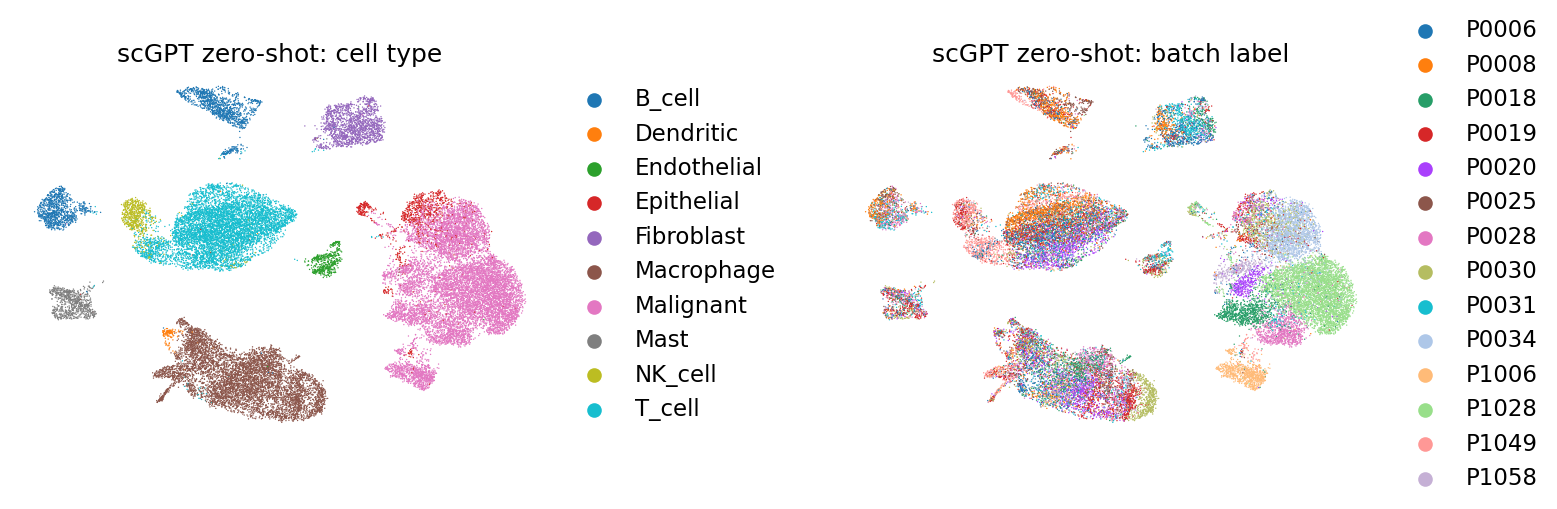

In [8]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[cell_type_key, batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: cell type", "scGPT zero-shot: batch label"])

## Evaluate the integration performance

In [9]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)

NMI...
ARI...
Silhouette score...
PC regression...


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Graph connectivity...


In [10]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.7988
AvgBATCH: 0.9465


## Comparison with HVG+PCs

We compute the HVG and PCs based on the dataset, this will serve as a trivial baseline for the integration performance.

In [11]:
adata = org_adata.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

UMAP of PCs colored by cell types and batch labels:

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


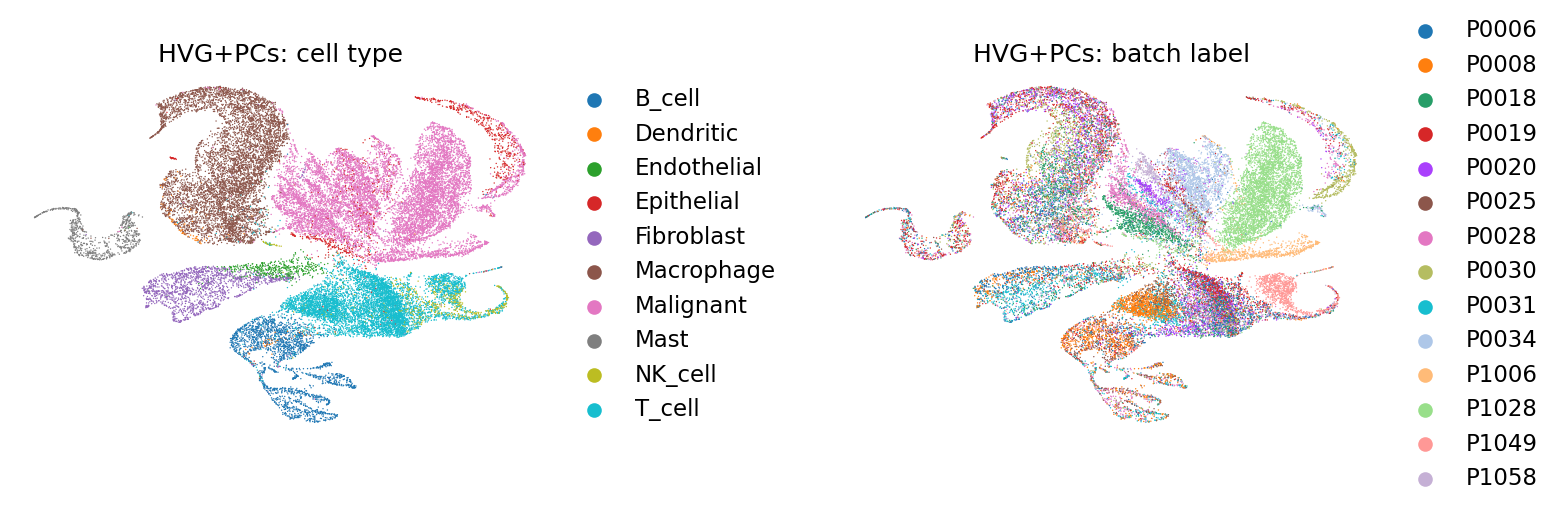

In [12]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color=[cell_type_key, batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=["HVG+PCs: cell type", "HVG+PCs: batch label"])

In [13]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)

NMI...
ARI...
Silhouette score...
PC regression...


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Graph connectivity...


In [14]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.6308
AvgBATCH: 0.7830


## Appendix: Zero-shot integration on COVID-19 dataset and MS dataset

### COVID-19 dataset

The dataset can be accessed form [here](https://drive.google.com/file/d/1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x/view?usp=drive_link).

In [15]:
# load dataset
adata = sc.read_h5ad('../save/data/covid_subsampled.h5ad')
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "str_batch"
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 313/313 [00:08<00:00, 36.94it/s]


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


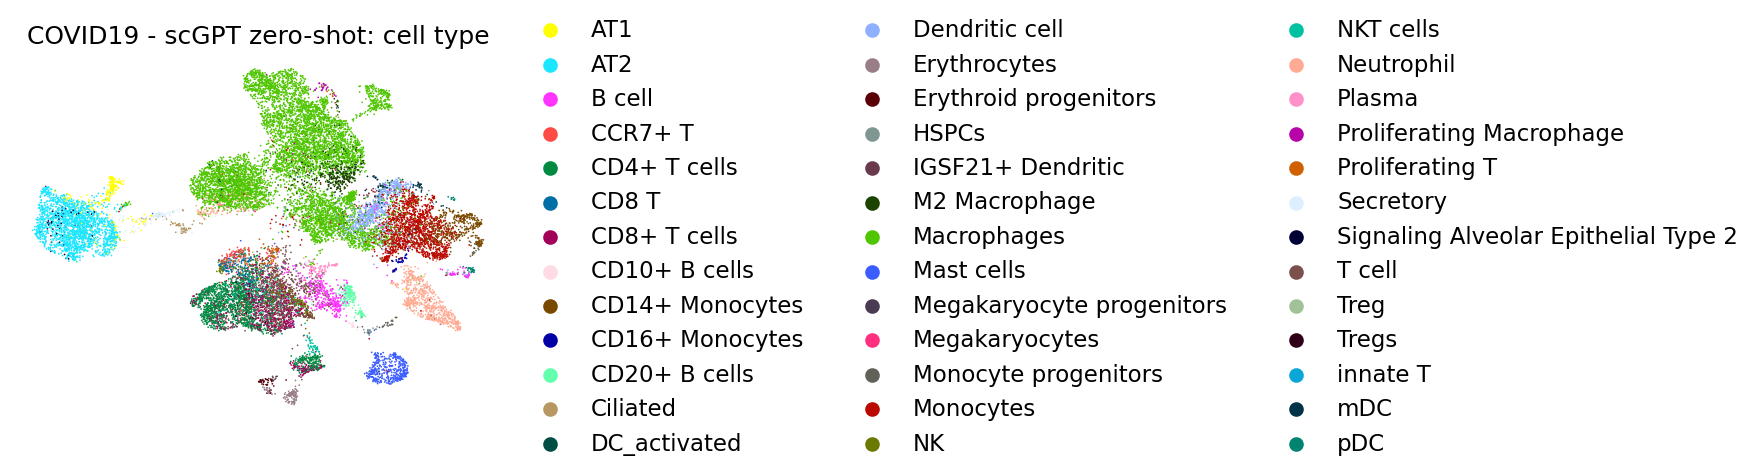

In [16]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[cell_type_key], 
           frameon=False, 
           title=["COVID19 - scGPT zero-shot: cell type"])

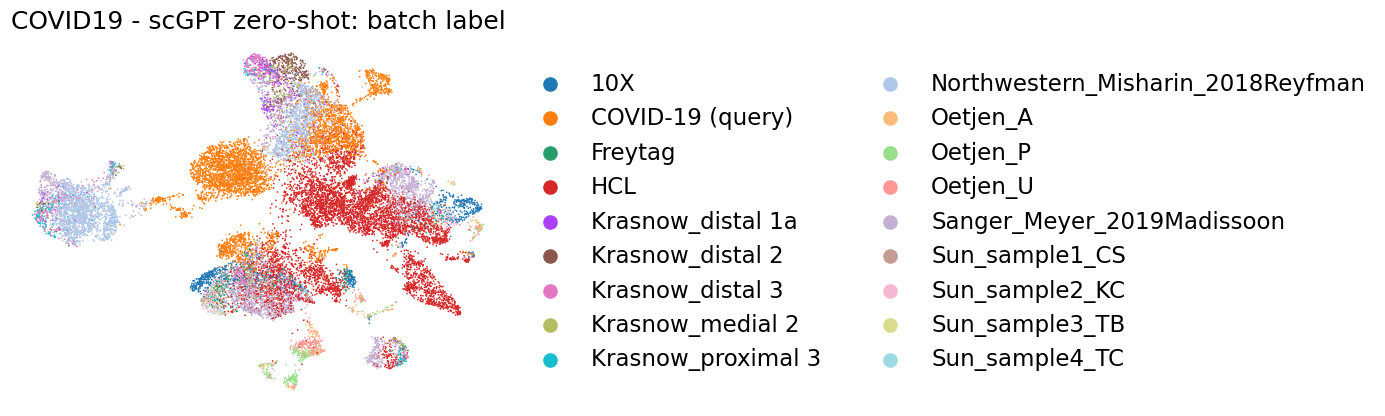

In [17]:
sc.pl.umap(embed_adata, 
           color=[batch_key], 
           frameon=False, 
           title=["COVID19 - scGPT zero-shot: batch label"])

In [18]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
AvgBIO: 0.4896
AvgBATCH: 0.8751


### MS dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing). As this is a preprocessed dataset, we will need to concatenate the training/test datasets together first.

In [19]:
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "Sample Characteristic[individual]"

train_data = sc.read_h5ad('../save/data/ms/c_data.h5ad')
test_data = sc.read_h5ad('../save/data/ms/filtered_ms_adata.h5ad')
test_data.var.index = test_data.var[gene_col]
adata = anndata.concat([train_data, test_data], join='outer')
adata.var[gene_col] = adata.var.index

embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 2808/3000 genes in vocabulary of size 60697.


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Embedding cells: 100%|██████████| 333/333 [00:20<00:00, 16.10it/s]


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


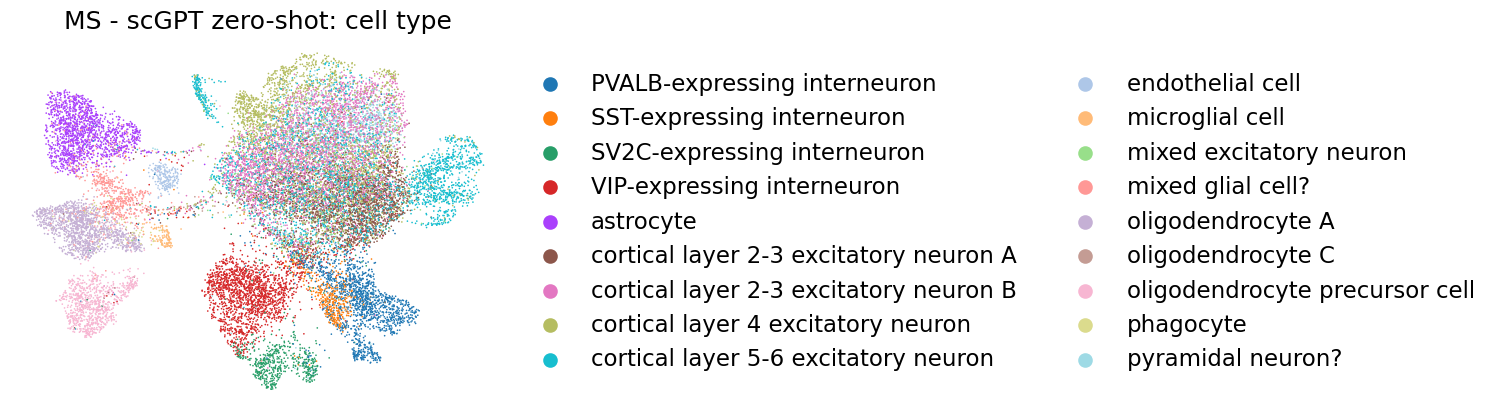

In [20]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[cell_type_key], 
           frameon=False, 
           title=["MS - scGPT zero-shot: cell type"])

/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


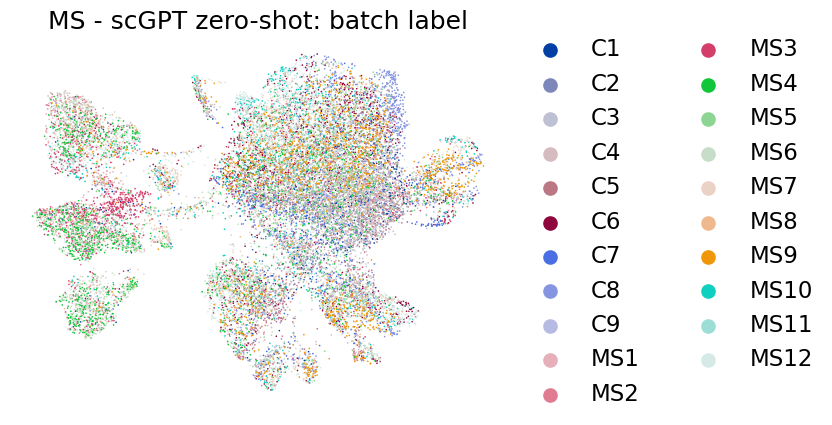

In [21]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[batch_key], 
           frameon=False, 
           title=["MS - scGPT zero-shot: batch label"])

In [22]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...


/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/pangkuan/dev/scgpt_env/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Graph connectivity...
AvgBIO: 0.4830
AvgBATCH: 0.9082
